When training a machine learning model, we would like to have the ability to monitor the model performance and perform certain actions depending on those performance measures. That’s where Keras Callbacks come in.

EarlyStopping() has a few options and by default:

1.monitor='val_loss': to use validation loss as performance measure to terminate the training.

2.patience=0: is the number of epochs with no improvement. The value 0 means the training is terminated as soon as the performance measure gets worse from one epoch to the next.

tf.compat: Runs the same on TensorFlow 1.15.0 and 2.0.0, even though session and placeholders were deprecated in 2.x. Likewise, tf.compat.v2 allows you to use things introduced in 2.x from 1.x. 

logging.set_verbosity: If you set it to the level as displayed (INFO), then TensorFlow will tell you all messages that have the label INFO (or more critical)

A metric is a function that is used to judge the performance of your model.

Accuracy class

tf.keras.metrics.Accuracy(name="accuracy", dtype=None)

Calculates how often predictions equal labels.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import numpy as np
import os

from utils import *
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback

%matplotlib inline 

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

print('Libraries are imported.')

Libraries are imported.


## Importing Data

The dataset is saved in a `data.csv` file.

In [2]:
column_names = ["Max Pax"	,"Range",	"Take off Weight",	"Empty Weight",	"S gross",	"Thrust",	"Lenght", "Height", "Span"]
df = pd.read_csv('aircraft.csv', names = column_names) #Importing csv file data.csv and storing the data in 'df'
df.head() 

,Max Pax,Range,Take off Weight,Empty Weight,S gross,Thrust,Lenght,Height,Span
0,56,1220,38.000,22.500,119.00,23810.0,30.58,8.08,25.55
1,195,10040,151.315,64.000,283.40,76000.0,46.61,12.93,44.42
2,186,6700,162.000,69.400,279.55,92600.0,53.12,12.35,43.20
3,219,6920,151.315,66.224,283.40,76000.0,46.61,12.93,44.42
4,129,4330,76.655,39.778,157.90,43500.0,40.59,10.36,32.92


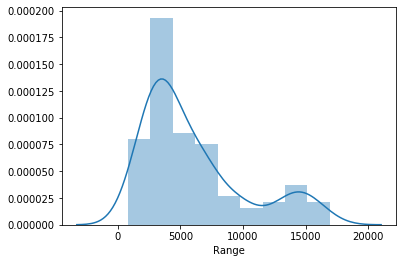

In [3]:
h1 = sns.distplot(df['Range'])
plt.show()

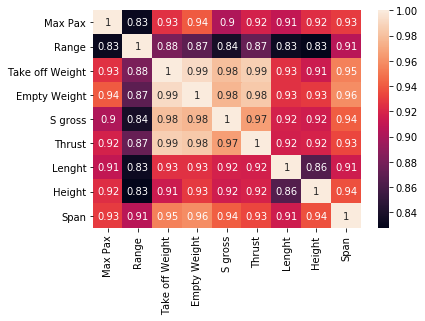

In [4]:
sp2 = sns.heatmap(df.corr(),annot = True) 

## Checking For Missing Data


In [5]:
df.isna().sum() 

Max Pax            0
Range              0
Take off Weight    0
Empty Weight       0
S gross            0
Thrust             0
Lenght             0
Height             0
Span               0
dtype: int64

## Data Normalization

In [6]:
#df = df.iloc[:,1:] 
df_norm = (df - df.mean()) / df.std()                                                 deviation of the whole column
df_norm.head()

,Max Pax,Range,Take off Weight,Empty Weight,S gross,Thrust,Lenght,Height,Span
0,-1.146895,-1.158944,-0.805293,-0.802812,-0.589610,-0.849382,-1.048210,-1.105361,-0.998191
1,-0.156068,0.972528,0.204752,-0.018314,0.527923,-0.064044,0.117888,0.135853,0.394806
2,-0.220222,0.165372,0.299994,0.083765,0.501752,0.185747,0.591457,-0.012581,0.304745
3,0.015010,0.218538,0.204752,0.023727,0.527923,-0.064044,0.117888,0.135853,0.394806
4,-0.626532,-0.407370,-0.460737,-0.476196,-0.325182,-0.553093,-0.320035,-0.521862,-0.454132


In [7]:
#y_mean = df['Take off Weight'].mean()
#y_std = df['Take off Weight'].std()

#def convert_label_value(pred):       #Defining a function which will convert the label values back to the original distribution and return it
#   return int(pred * y_std + y_mean)
#y_mean = pd.Series(df.mean(axis=0).drop(['Max Pax', 'Range'])).array
#y_std = pd.Series(df.std(axis=0).drop(['Max Pax', 'Range'])).array
#def convert_label_value(pred):
#    items = []#Defining a function which will convert the label values back to the original distribution and return it
 #   for item in pred:
  #      int(pred * y_std[4] + y_mean[4])
   #     items = items.append(item)
    #return items



In [8]:
yms = df.to_numpy()
y_mean = yms.mean(axis = 0)
y_mean = np.delete(y_mean, [0,1])
y_std = yms.std(axis = 0)
y_std = np.delete(y_std, [0,1])
def convert_label_value(pred):
    #preds = pred.to_numpy
    result = np.multiply(pred, y_std) + y_mean
    return result

## Creating Training and Test Sets

In [9]:
X = df_norm.iloc[:, :2] 
X.head()

,Max Pax,Range
0,-1.146895,-1.158944
1,-0.156068,0.972528
2,-0.220222,0.165372
3,0.015010,0.218538
4,-0.626532,-0.407370


In [10]:
Y = df_norm.iloc[:,2:9] 
Y.head()

,Take off Weight,Empty Weight,S gross,Thrust,Lenght,Height,Span
0,-0.805293,-0.802812,-0.589610,-0.849382,-1.048210,-1.105361,-0.998191
1,0.204752,-0.018314,0.527923,-0.064044,0.117888,0.135853,0.394806
2,0.299994,0.083765,0.501752,0.185747,0.591457,-0.012581,0.304745
3,0.204752,0.023727,0.527923,-0.064044,0.117888,0.135853,0.394806
4,-0.460737,-0.476196,-0.325182,-0.553093,-0.320035,-0.521862,-0.454132


In [11]:
X_arr = X.values
Y_arr = Y.values

print('X_arr shape: ', X_arr.shape) 
print('Y_arr shape: ', Y_arr.shape)

X_arr shape:  (104, 2)
Y_arr shape:  (104, 7)


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_arr, Y_arr, test_size = 0.15, shuffle = True, random_state=3) 


print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('X_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (88, 2)
y_train shape:  (88, 7)
X_test shape:  (16, 2)
y_test shape:  (16, 7)


## Creating the Model

In [13]:

def get_model():
    model = Sequential([
        Dense(10, input_shape = (2,), activation = 'tanh'), 
        Dense(25, activation = 'tanh'),  
        Dense(10, activation = 'tanh'),
        Dense(7, activation = 'tanh'),
    ])

    model.compile(
        loss='mse',    
        optimizer='SGD'                               
    )
    
    return model
 
model = get_model()

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                30        
_________________________________________________________________
dense_1 (Dense)              (None, 25)                275       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                260       
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 77        
Total params: 642
Trainable params: 642
Non-trainable params: 0
_________________________________________________________________


## Model Training

In [14]:
early_stopping = EarlyStopping(monitor='val_loss', patience = 5)

model = get_model()

preds_on_untrained = model.predict(X_train)

#Finally training the model-->
history = model.fit(
    X_train, y_train,
    validation_data = (X_test, y_test),
    batch_size = 25,
    epochs = 500,
    callbacks = [early_stopping],
    verbose = 0
)

In [15]:
def plot_loss(history):
    h = history.history
    #x_lim = len(h['loss'])
    plt.figure(figsize=(8, 8))
    plt.plot(h['val_loss'], label = 'Validation Loss')
    plt.plot(h['loss'], label = 'Training Loss')
    h1 = h['loss'][-1]
    h2 = h['val_loss'][-1]
    print(f'Loss is: {h1:.4f} \nvalidation Loss is: {h2:.4f}\n')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    return 

Loss is: 0.2510 
validation Loss is: 0.2118



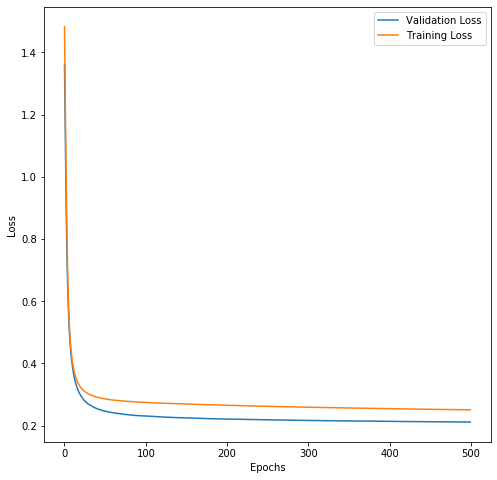

In [16]:
plot_loss(history)


## Final Predictions

In [17]:
def compare_predictions(preds1, preds2, y_test):
    plt.figure(figsize=(8,8))
    plt.plot(preds1, y_test, 'ro', label='Untrained Model')
    plt.plot(preds2, y_test, 'go', label='Trained Model')
    plt.xlabel('Preds')
    plt.ylabel('Labels')
    
    y_min = min(min(y_test), min(preds1), min(preds2))
    y_max = max(max(y_test), max(preds1), max(preds2))
    
    plt.xlim([y_min, y_max])
    plt.ylim([y_min, y_max])
    plt.plot([y_min, y_max], [y_min, y_max], 'b--')
    plt.legend()
    plt.show()
    return

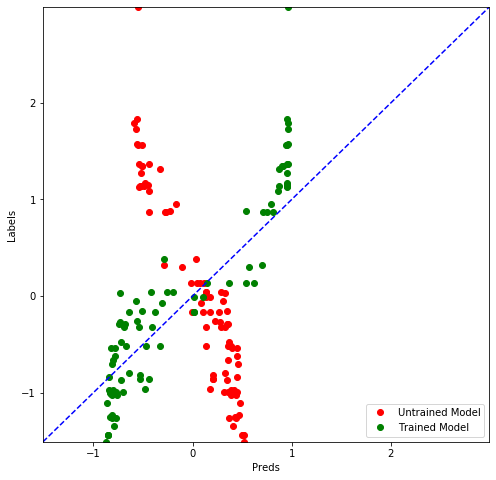

In [18]:
preds_on_trained = model.predict(X_train)

compare_predictions(preds_on_untrained[:,5], preds_on_trained[:,5], y_train[:,5])

In [19]:
Input = [179, 4800]

#a = int(input("Please enter pax number: " ))
#b =int(input("Please enter range: " ))
#Input = [a, b]
X_test1 = [216.89423, 6015.6923]
X_test2 = np.array(Input) - np.array(X_test1)
X_test3 = np.divide(X_test2,[139.61, 4118.04391])
X_test4 = X_test3.reshape(1,2)

preds_on1 = model.predict(X_test4)
preds_on2 = convert_label_value(preds_on1)
preds_on = preds_on2[0]
g = df.iloc[48, 2:].to_numpy()
subtract = preds_on - g
Error = abs(np.divide(subtract, g)*100)

print(f'\nReal values are is:\n\nTake off Weight {g[0]:.2f} tons\nEmpty Weight:{g[1]:.2f} tons \n\
S gross: {g[2]:.2f} m^2\nThrust: {g[3]:.2f} lbs\nLength: {g[4]:.2f} m\nHeight: {g[5]:.2f} m\nSpan: {g[6]:.2f} m')

print(f'\nPredictions are:\n\nTake off Weight {preds_on[0]:.2f} tons\nEmpty Weight:{preds_on[1]:.2f} tons\n\
S gross: {preds_on[2]:.2f} m^2\nThrust: {preds_on[3]:.2f} lbs\nLength: {preds_on[4]:.2f} m\nHeight: {preds_on[5]:.2f} m\nSpan: {preds_on[6]:.2f} m')

print(f'\nErrors are:\n\nTake off Weight {Error[0]:.2f}%\nEmpty Weight:{Error[1]:.2f}%\n\
S gross: {Error[2]:.2f}%\nThrust: {Error[3]:.2f}%\nLength: {Error[4]:.2f}%\nHeight: {Error[5]:.2f}%\nSpan: {Error[6]:.2f}%')


Real values are is:

Take off Weight 73.50 tons
Empty Weight:42.10 tons 
S gross: 122.40 m^2
Thrust: 54000.00 lbs
Length: 37.57 m
Height: 11.76 m
Span: 34.09 m

Predictions are:

Take off Weight 81.68 tons
Empty Weight:41.08 tons
S gross: 143.61 m^2
Thrust: 51964.74 lbs
Length: 41.04 m
Height: 10.93 m
Span: 33.88 m

Errors are:

Take off Weight 11.13%
Empty Weight:2.43%
S gross: 17.33%
Thrust: 3.77%
Length: 9.22%
Height: 7.02%
Span: 0.62%
